# Gaston tutorial

Gaston is a plotting package for Julia that relies on gnuplot. It focuses on fast, simple plotting, and leaves publication-quality plots to tools such as pgfplots. This tutorial covers Gaston version 0.7.

Gaston's code repository is [here](https://github.com/mbaz/Gaston.jl).

## Installation

Make sure that [gnuplot](https://gnuplot.info) is installed on your system and in the system path. Confirm by running in Julia:

In [1]:
run(`gnuplot --version`)

gnuplot 5.2 patchlevel 2


Any errors here mean that gnuplot is not properly installed.

Once gnuplot is functional, install Gaston using Julia's package manager by running `Pkg.add("Gaston")`.

## Overview of main plotting commands

Gaston offers four types of plots: regular 2D plots, surface (3D) plots, histograms, and images. Start by loading it into your Julia session:

In [2]:
using Gaston

### 2D plots

To plot a vector `y` against a vector `x`, use the command `plot`.

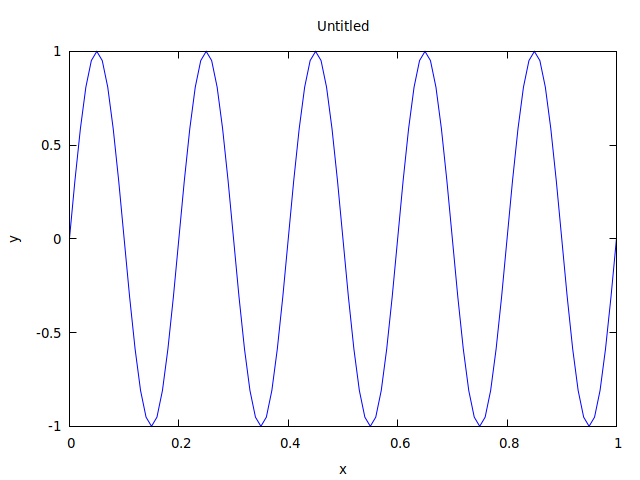

In [3]:
t = 0:0.01:1
plot(t, sin.(2π*5*t));

You may control certain properties of the axes, as well as the curve. Axes properties are:

* `title`
* `xlabel`
* `ylabel`
* `grid` (allowed values: `""`, `"on"` or `"off"`)
* `xrange`
* `yrange`
* `box`

A curve's properties are:

* `plotstyle` (allowed values are given in `Gaston.supported_2Dplotstyles` variable)
* `legend`
* `color`
* `linewidth`
* `linestyle` (a string containing a combination of `-`, `.`, `_` and space; empty string plots solid line)
* `pointsize`
* `marker` (allowed values are given in `Gaston.supported_markers` variable)

These follow GnuPlot's standard syntax, and can be set by setting each property in the `plot` command. For example:

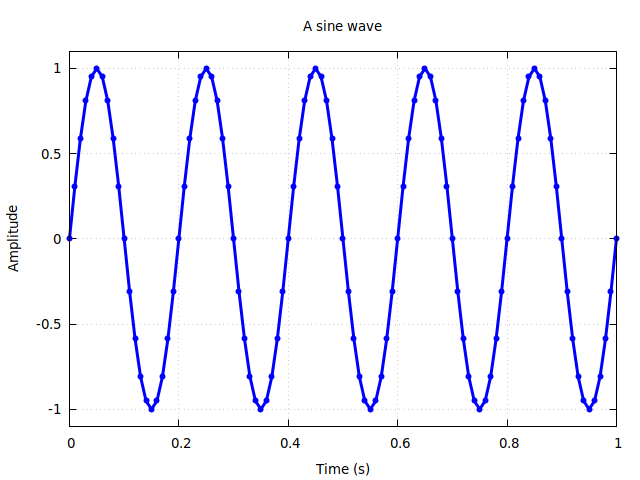

In [4]:
plot(t,sin.(2π*5*t),title="A sine wave",xlabel="Time (s)",ylabel="Amplitude",grid="on",linewidth=3,color="blue",
    yrange="[-1.1:1.1]",marker="ecircle",plotstyle="linespoints");

Note that, if the `x` coordinate is ommited, the indices of `y` will be used instead.

Other curves can be added to the same plot by using the `plot!()` command. Only curve properties can be used with this command; the axes properties remain unchanged.

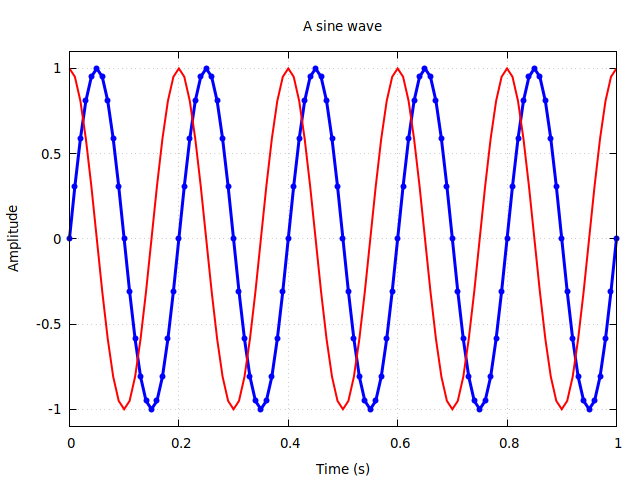

In [5]:
plot!(t,cos.(2π*5*t),color="red",linewidth=2);

### 3D plots

Gaston can plot 3D surfaces using the `surf` command, which works in two different ways. The first is by giving it explicit `x`, `y` and `z` coordinates.

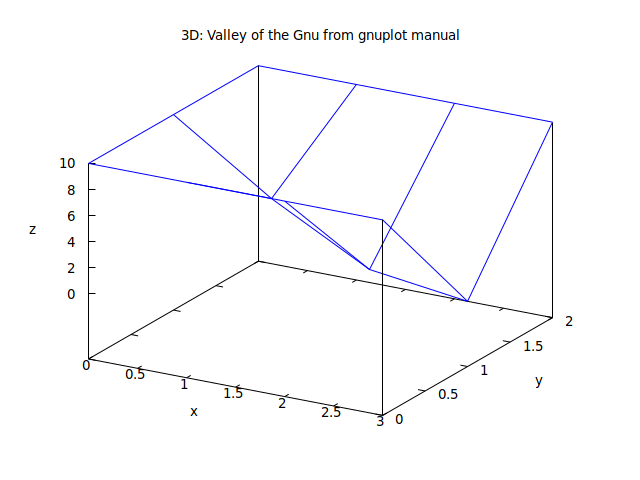

In [6]:
x=[0,1,2,3]
y=[0,1,2]
Z=[10 10 10; 10 5 10;10 1 10; 10 0 10]
surf(x,y,Z,title = "3D: Valley of the Gnu from gnuplot manual");

The second alternative is to pass `x`, `y` coordinates to a function.

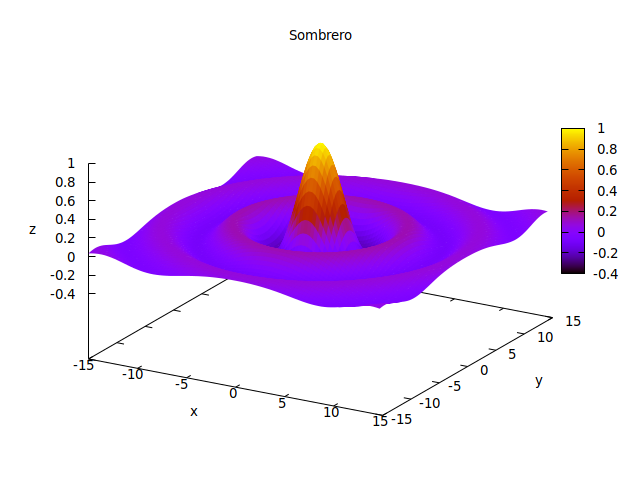

In [7]:
x = y = -15:0.33:15
surf(x,y,(x,y)->sin(sqrt(x.*x+y.*y))/sqrt(x.*x+y.*y),title="Sombrero",plotstyle="pm3d");

Note that the `surf` command takes the same options as `plot`, with the addition of the `zrange` axes property.

### Images

The command to plot an image is `imagesc`. It can plot a scaled or RGB image, depending on whether the `z` argument is an array with two or three dimensions. This command takes the properties `title`, `xlabel` and `ylabel`. In addition, RGB images can take a parameter `clim`, which must be a two-element array, and which is used to scale the image values.

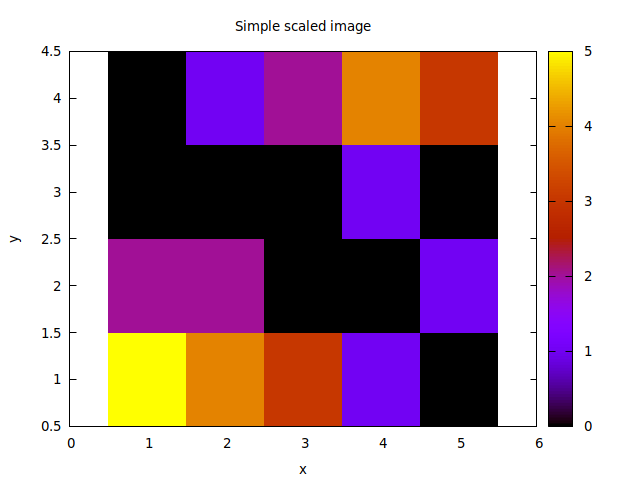

In [8]:
Z = [5 4 3 1 0; 2 2 0 0 1; 0 0 0 1 0; 0 1 2 4 3]
imagesc(Z,title="Simple scaled image");

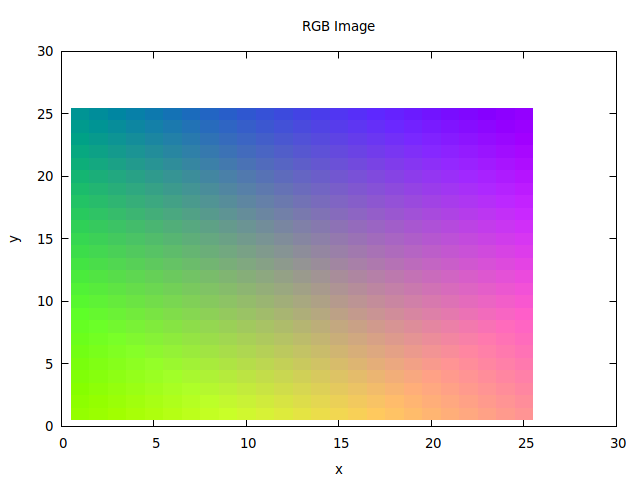

In [9]:
R = [ x+y for x=0:5:120, y=0:5:120]
G = [ x+y for x=0:5:120, y=120:-5:0]
B = [ x+y for x=120:-5:0, y=0:5:120]
Z = zeros(25,25,3)
Z[:,:,1] = R
Z[:,:,2] = G
Z[:,:,3] = B
imagesc(Z,title="RGB Image",clim=[10 200]);

### Histograms

To plot histograms, use the `histogram` command. This command takes the same properties as `plot`. In addition, the property `bins` is used to specify the number of bins, and `norm` can be used to normalize the area under the histogram.

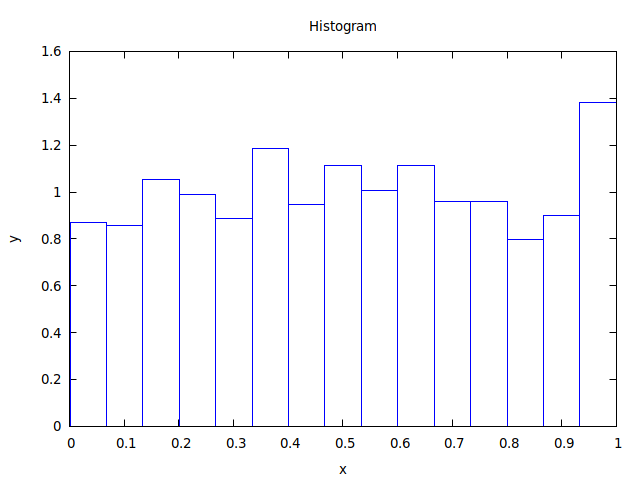

In [10]:
histogram(rand(1000),bins=15,norm=1,title="Histogram",yrange="[0:1.6]");

## Financial and error bars

Gaston supports plotting using financial bars.

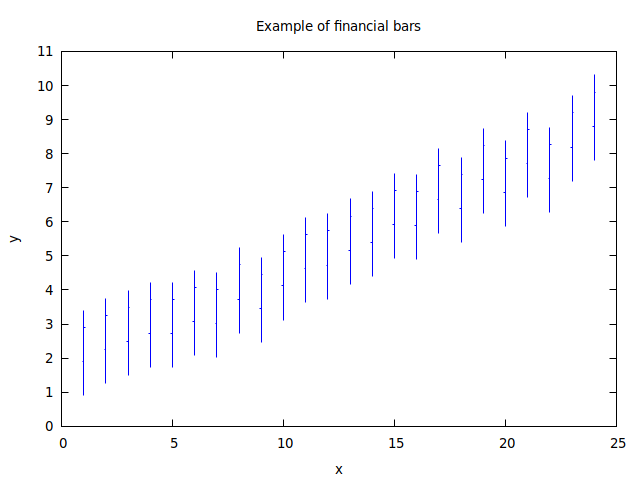

In [11]:
y = [i+rand() for i=1:0.3:8]
open=y.-0.1*rand(length(y));
close=open.+1;
low=open.-1;
high=open.+1.5;
fin = Gaston.FinancialCoords(open,low,high,close)
plot(y,financial=fin,title="Example of financial bars",plotstyle="financebars");

Error bars  and error lines are also supported.

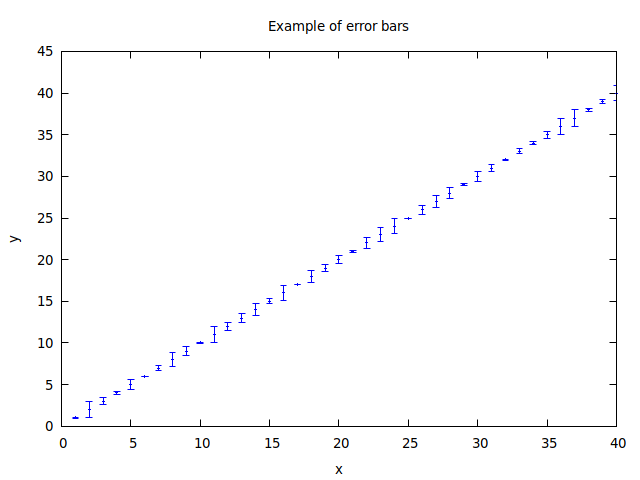

In [12]:
y = 1:40
err = Gaston.ErrorCoords(rand(40))
plot(y,err=err,title="Example of error bars",plotstyle="errorbars");

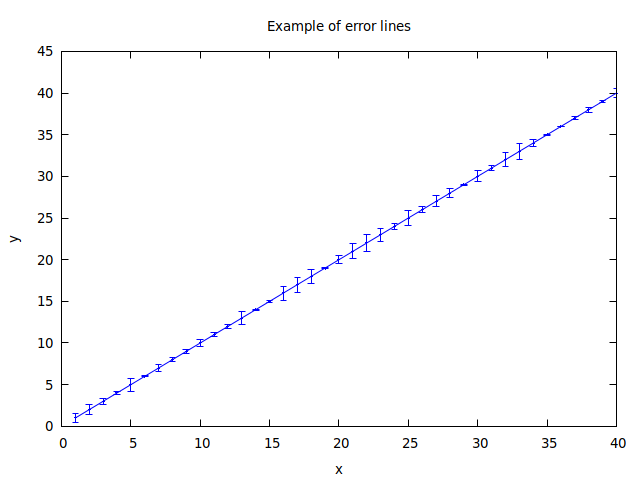

In [13]:
y = 1:40
err = Gaston.ErrorCoords(rand(40))
plot(y,err=err,title="Example of error lines",plotstyle="errorlines");

## Figure handles

Gnuplot has the ability to create and manage multiple figures (windows) simultaneously. This is not useful in a Jupyter notebook, but can be convenient in a desktop environment. Each figure is identified by a unique handle. Handles are integers larger than 0.

* `h = figure()` creates a new figure with the smallest available handle
* `figure(h)` selects (if existing) or creates a figure with handle `h`
* All plot commands return the handle of the figure where the plot was made
* All plot commands take a handle as optional argument to indicate the figure where the plot action will be taken
* `closefigure(h)` can be used to close and delete figure with handle `h` (or more recently used figure if no argument is given)
* `closeall()` closes all figures

## Building an image manually

Sometimes one needs more flexibility than that provided by the high-level plot commands described above. As an example, let's consider the case where we want to plot a theoretical Gaussian PDF along with an experimental Gaussian histogram on the same figure. This can be accomplished by building each individual part of the plot by hand.

In Gaston, a figure (which corresponds to a GnuPlot window or plot) has the following structure (which can be seen in the source file `gaston_types.jl`):

* Figure
    * handle
    * AxesConf
        * title, xlabel, ylabel, zlabel, fill, grid, box, axis, {x,y,z}range
    * Vector of Curves
        * Each curve has `x`, `y`, `z`, coordinates plus financial and error bars, and a configuration
        * A curve configuration consists of values for legend, plotstyle, color, marker, linewidth, and pointsize

To achieve our objective we need to create a histogram curve, a regular curve, an AxesConf object, put them together in a Figure and finally call the low-level plot function of the figure. This can be achieved as follows.

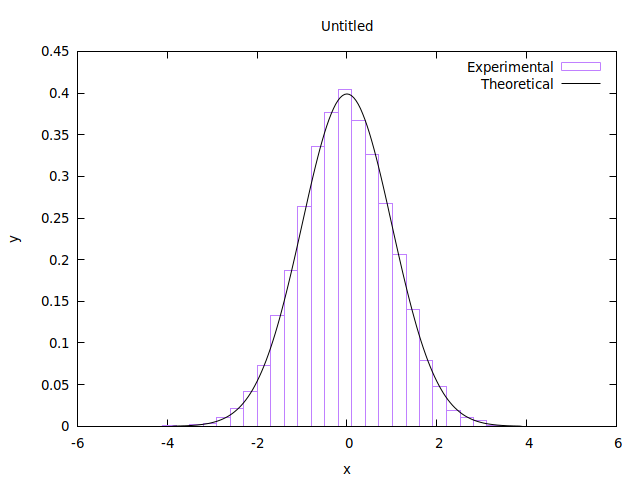

In [14]:
# first, create the experimental histogram and store the handle
h = histogram(randn(10000),bins=25,norm=1,legend="Experimental", color="purple")
# second, calculate the theoretical density and add it to the figure
x2 = -5:0.05:5
theo_pdf = @. 1/sqrt(2π)*exp((-x2^2)/2)  # theoretical Gaussian density
theo_cconf = Gaston.CurveConf(color="black",legend="Theoretical")  # configuration of theoretical curve
theo_curve = Gaston.Curve(x2,theo_pdf,theo_cconf)  # the actual theoretical curve
# finally, plot
Gaston.push_figure!(h,theo_curve)  # push curve to the figure with handle h
Gaston.llplot(); # call the low-level plot command

As a second example, we will now plot two surfaces on the same figure.

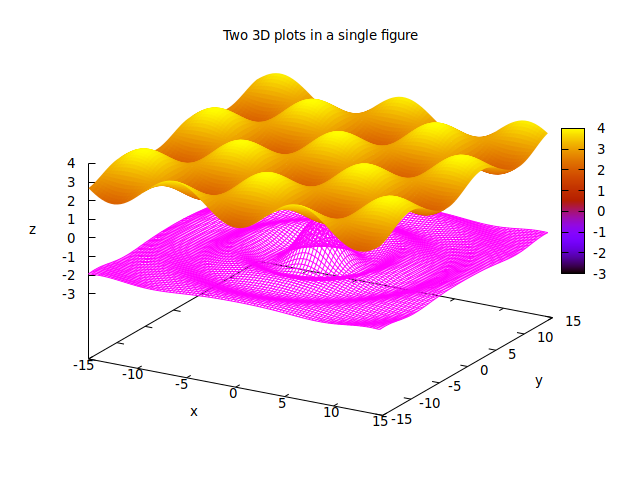

In [15]:
x = -15:0.33:15
y = -15:0.33:15
Z1 = Gaston.meshgrid(x,y,(x,y)->2sin(sqrt(x.*x+y.*y))/sqrt(x.*x+y.*y)-2)
h = surf(x,y,Z1,title="Two 3D plots in a single figure", plotstyle="lines",color="magenta")
Z2 = Gaston.meshgrid(x,y,(x,y)->cos(x/2)*sin(y/2)+3)
c = Gaston.Curve(x,y,Z2,Gaston.CurveConf(plotstyle="pm3d"))
Gaston.push_figure!(h,c)
Gaston.llplot()

## Setting defaults

Whenever a parameter is not specified by the user, Gaston uses a default value. These can be changes with the `set` command. For example, if you like all your plots to be colored cyan:

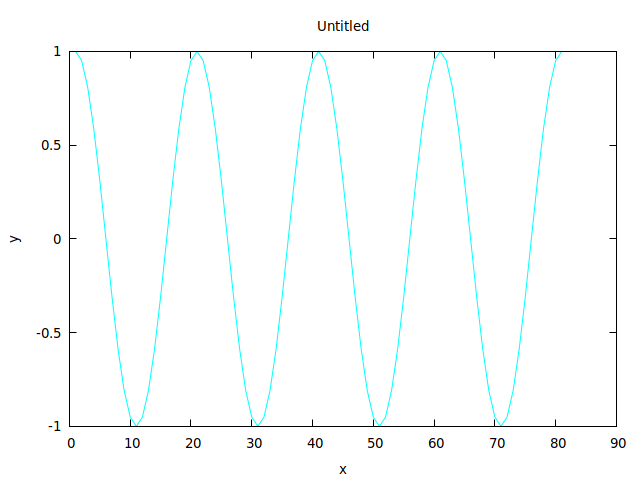

In [16]:
set(color="cyan")  # all future plots will be colored cyan
plot(cos.(2π*10*(0:0.005:0.4)));
set(color="blue") # revert to default

One thing you may want to do is set the default terminal type, which is `"wxt"` by default. MacOS users, for instance, may prefer `"aqua"`, or maybe revert to the primitive but more compatible `"x11"`:

* `set(terminal="x11")` sets the terminal to type `x11`.

Note that several properties may be specified at the same time:

* `set(terminal="qt",axis="semilogy",title="My favorite title")`

Note also that the terminal type cannot be changed within a Jupyter notebook.

## Saving a plot to a file

A given plot can be saved to a file using the `printfigure` command, which takes three keyword arguments:

* `handle`: the handle of the figure to plot (defaults to current figure)
* `term`: defines the terminal used by gnuplot to save the figure. Supported values are `png`, `pdf`, `svg`, `gif`, and `eps`.
* `outputfile`: the name of the output file (including extension). A default filename can be configured using `set`.

There are five variables that affect how a plot is saved:

* print_color
* print_fontface
* print_fontscale
* print_linewidth
* print_size

See gnuplot's documentation for details. Keep in mind that different terminal interpret these differently; for example, the pdf terminal interprets the size as inches; a reasonable setting for the size would be something like `set(print_size="5in, 3in")`. The `png` terminal, though, expects the size to be given in pixels.

Note that the `printfigure` command is disabled inside a Jupyter notebook.

## Low-level interaction with gnuplot

### `gnuplot_send()`

In order to access a feature supported by gnuplot but not exposed by Gaston, you can issue direct commands to gnuplot using `gnuplot_send(s)`. Here, `s` is a string that will be sent directly to gnuplot for execution.

However, note that high-level commands such as `plot` reset a figure before plotting, potentially removing the effect of commands issued via `gnuplot_send`. To solve this, commands `plot`, `surf`, `imagesc` and `histogram` take an optional argument, `gpcom`, which must be a string, and which is sent to gnuplot right after the terminal type is set. An example is shown below, where `gpcom` is used to change the default view of a 3D plot.

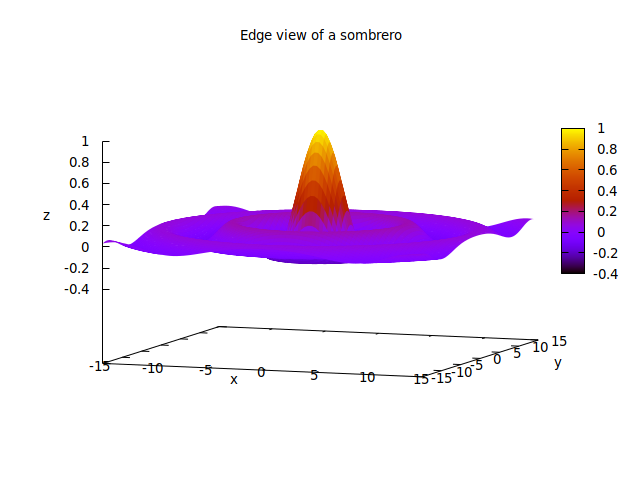

In [17]:
x = y = -15:0.33:15
surf(x,y,(x,y)->sin(sqrt(x.*x+y.*y))/sqrt(x.*x+y.*y),title="Edge view of a sombrero",plotstyle="pm3d",gpcom="set view 80,20");

### Handling errors

Gaston goes to some lengths to avoid this, but it is possible to send commands that cause gnuplot to error out. When this happens, no plot or error messages will be produced. It is possible to dig into Gaston's bowels to see if it caught gnuplot's error. First, let's cause an error on purpose:

In [18]:
plot(1:10,color="nonexisting");


gnuplot> plot '/tmp/gaston-PByNckvm-1'  i 0 notitle  with lines linecolor rgb 'nonexisting' lw 1 
                                                                                            ^
         line 0: unrecognized color name and not a string "#AARRGGBB" or "0xAARRGGBB"



If Gaston received the error from gnuplot, then this flag will be true:

In [19]:
println(Gaston.gnuplot_state.gp_error)

true


The variable is true, meaning that Gaston captured the error from gnuplot. The actual error value can be obtained as follows:

In [20]:
println(Gaston.gnuplot_state.gp_lasterror)


gnuplot> plot '/tmp/gaston-PByNckvm-1'  i 0 notitle  with lines linecolor rgb 'nonexisting' lw 1 
                                                                                            ^
         line 0: unrecognized color name and not a string "#AARRGGBB" or "0xAARRGGBB"




Here, we can clearly see that the problem was the color name. Let us fix it:

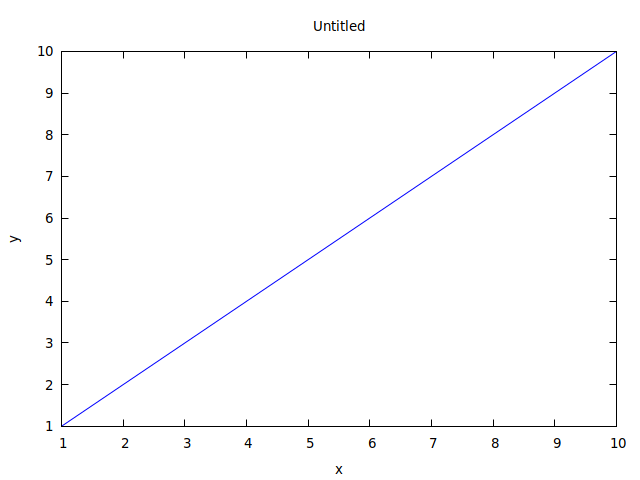

In [21]:
figure()
plot(1:10,color="blue");

In [22]:
println(Gaston.gnuplot_state.gp_error)

false
